In [1]:
!nvidia-smi

Mon Dec 18 15:15:57 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
%pip install -U autotrain-advanced

In [2]:
PROJECT_NAME = "Dreambooth_SDXL"
MODEL_NAME = "stabilityai/stable-diffusion-xl-base-1.0"
DATA_DIR = "/content/rashmika_photos"
REPO_ID = "kr-manish/text-to-image-sdxl-lora-dreemBooth-rashmika"

In [3]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):
    assert len(imgs) == rows * cols

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]

    w, h = imgs[0].size
    grid_w, grid_h = cols * w, rows * h
    grid = Image.new("RGB", size=(grid_w, grid_h))

    for i, img in enumerate(imgs):
        x = i % cols * w
        y = i // cols * h
        grid.paste(img, box=(x, y))

    return grid

import glob

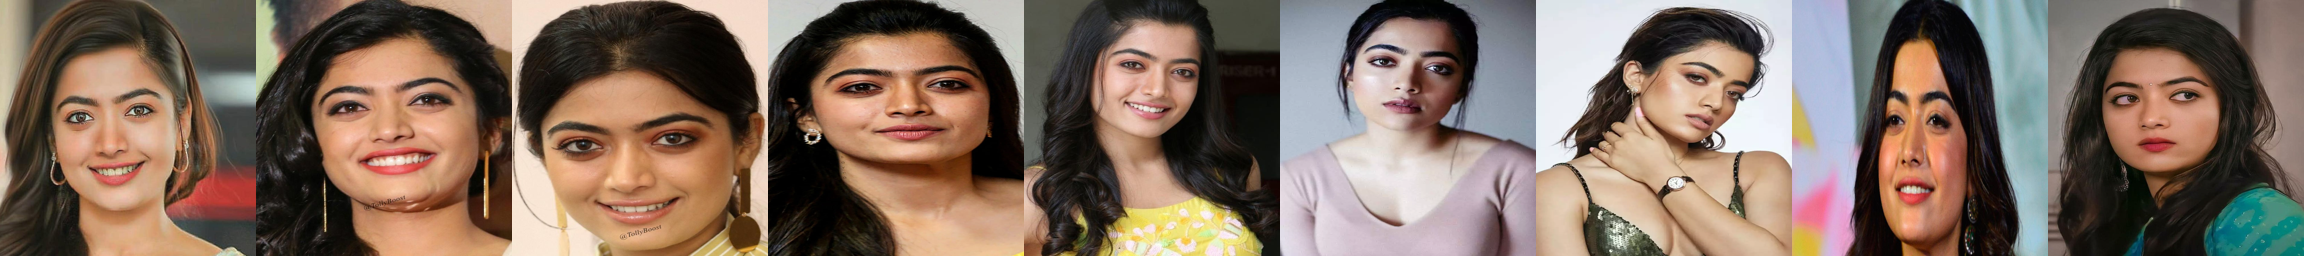

In [4]:
imgs = [Image.open(path) for path in glob.glob("/content/rashmika_photos/*.jpg")]
image_grid(imgs, 1, 9)

In [5]:
from huggingface_hub import notebook_login
notebook_login()

In [6]:
!autotrain dreambooth \
--model $MODEL_NAME \
--project-name $PROJECT_NAME \
--image-path $DATA_DIR \
--prompt "A photo of rashmika mehta wearing casual clothes, taking a selfie, and smiling." \
--resolution 1024 \
--batch-size 1 \
--num-steps 300 \
--gradient-accumulation 4 \
--lr 1e-4 \
--fp16 \
--gradient-checkpointing \
--push-to-hub \
--repo-id $REPO_ID


> INFO    Namespace(version=False, model='stabilityai/stable-diffusion-xl-base-1.0', revision=None, tokenizer=None, image_path='/content/rashmika_photos', class_image_path=None, prompt='A photo of rashmika mehta wearing casual clothes, taking a selfie, and smiling.', class_prompt=None, num_class_images=100, class_labels_conditioning=None, prior_preservation=None, prior_loss_weight=1.0, project_name='Dreambooth_SDXL', seed=42, resolution=1024, center_crop=None, train_text_encoder=None, batch_size=1, sample_batch_size=4, epochs=1, num_steps=300, checkpointing_steps=100000, resume_from_checkpoint=None, gradient_accumulation=4, gradient_checkpointing=True, lr=0.0001, scale_lr=None, scheduler='constant', warmup_steps=0, num_cycles=1, lr_power=1.0, dataloader_num_workers=0, use_8bit_adam=None, adam_beta1=0.9, adam_beta2=0.999, adam_weight_decay=0.01, adam_epsilon=1e-08, max_grad_norm=1.0, allow_tf32=None, prior_generation_precision=None, local_rank=-1, xformers=None, pre_compute_text_embeddi

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

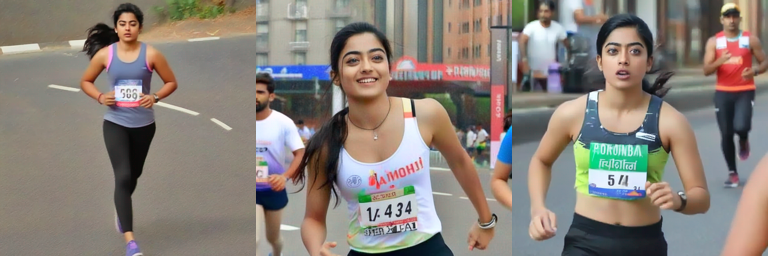

In [7]:
from diffusers import DiffusionPipeline, AutoencoderKL, StableDiffusionXLImg2ImgPipeline

import torch

vae = AutoencoderKL.from_pretrained(
    "madebyollin/sdxl-vae-fp16-fix",
    torch_dtype=torch.float16
)
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True,
)
pipe.to("cuda");
#pipe.load_lora_weights(REPO_ID, weight_name="pytorch_lora_weights.safetensors")
pipe.load_lora_weights("/content/Dreambooth_SDXL", weight_name="/content/Dreambooth_SDXL/pytorch_lora_weights.safetensors")


prompt = "A photo of rashmika mehta participating in a marathon."

image = pipe(prompt=prompt, num_inference_steps=25, num_images_per_prompt = 3)
image_grid(image.images, 1, 3)

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

  0%|          | 0/25 [00:00<?, ?it/s]

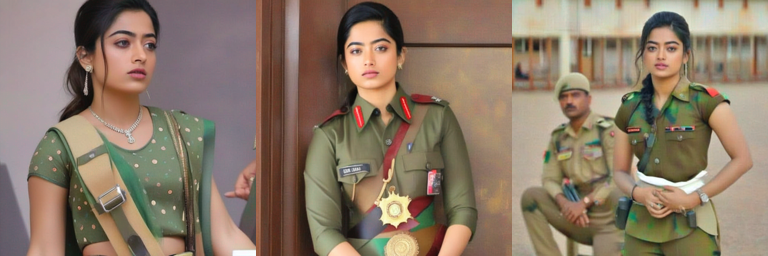

In [8]:
#prompt = "A photo of manish kumar giving a press conference."
prompt = "A photo of rashmika mehta waring  a indian army clothes."

image = pipe(prompt=prompt, num_inference_steps=25, num_images_per_prompt = 3)
image_grid(image.images, 1, 3)

In [ ]:
prompt = "A photo of rashmika mehta is swimming in ocean."

seed = 65
generator = torch.Generator("cuda").manual_seed(seed)
image = pipe(prompt=prompt, num_inference_steps=25, generator=generator).images[0]
image.resize((300, 300))

In [ ]:
refiner = StableDiffusionXLImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
)
refiner.to("cuda");

image = refiner(prompt=prompt, num_inference_steps=25, generator=generator, image=image)
image.images[0].resize((300, 300))

In [9]:

from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

Mounted at /content/gdrive
 Asus_shared
 BIOINF
 cGAN_model
 cGAN_xray
'Colab Notebooks'
 cycleGAN_model_47000_h2z
 duracell_battery_forecast
 duracell_battery_forecast.ipynb
 FineTuning_test
 grocery_void_match_missing_count
 Shared_CycleGAN_h2z
'shp_source <- fread("step_0_shipmentfile_Arkieva_01-04-2023.csv")  #Reading it from blob # bl_endp_key <- storage_endpoint("~ource$monthyear<-as.yearmon(shp_source$Delivery_Date)    build other config file for file path and read data from above file.gdoc'
 softweb
 softweb_proj
 text-to-image_custom_stableDiffusion_DreamBooth_v2.ipynb
 text-to-image_sdxl_dreamBooth_custom
 VID20230630142456.mp4
 VID20230630143037.mp4
 yolov3
 yolov3_
 yolov3_cig_smoke_v2
 yolov5_cv2


In [11]:
!cp -r /content/rashmika_photos /content/gdrive/MyDrive/text-to-image_sdxl_dreamBooth_custom/rashmika_trained_model_dataa